In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np

In [2]:
data = pd.read_csv('/bigdata/data/5/TravelInsurancePrediction.csv', index_col=0)
data.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


Датасет содержит информацию о клиентах и факт покупки ими страховки.

Описание столбцов:

Age - возраст клиента *(численная переменная)*

Employment Type - сектор экономики, в котором работает клиент *(категориальная переменная)*

GraduateOrNot - выпустился ли клиент из колледжа *(категориальная переменная)*

AnnualIncome - годовой доход в индийских рупиях *(численная переменная)*

FamilyMembers - количество членов семьи клиента *(численная переменная)*

ChronicDiseases - страдает ли клиент каким-либо серьезным заболеванием или состоянием, например диабет, повышенное давление и др. *(категориальная переменная)*

FrequentFlyer - совершил ли клиент 4 или более путешествия на самолете за последние 2 года *(категориальная переменная)*

EverTravelledAbroad - был ли клиент когда-нибудь заграницей (за всю жизнь) *(категориальная переменная)*

**TravelInsurance** - купил ли клиент страховку, предлагаемую компанией *(целевая переменная, бинарная категориальная)*

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1987 non-null   int64 
 1   Employment Type      1987 non-null   object
 2   GraduateOrNot        1987 non-null   object
 3   AnnualIncome         1987 non-null   int64 
 4   FamilyMembers        1987 non-null   int64 
 5   ChronicDiseases      1987 non-null   int64 
 6   FrequentFlyer        1987 non-null   object
 7   EverTravelledAbroad  1987 non-null   object
 8   TravelInsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 155.2+ KB


In [4]:
data.isna().sum()

Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64

In [5]:
cat_cols = ['Employment Type', 'GraduateOrNot', 'ChronicDiseases', 'FrequentFlyer', 'EverTravelledAbroad']
num_cols = ['Age', 'AnnualIncome', 'FamilyMembers']
feature_cols = cat_cols + num_cols
target_col = 'TravelInsurance'

Хочется сразу перевести ChronicDiseases в формат 'Yes'/'No', как все остальные похожие

In [6]:
data['ChronicDiseases'] = data['ChronicDiseases'].apply(lambda x: 'Yes' if x else 'No')
data.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,Yes,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,No,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,Yes,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,Yes,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,Yes,Yes,No,0


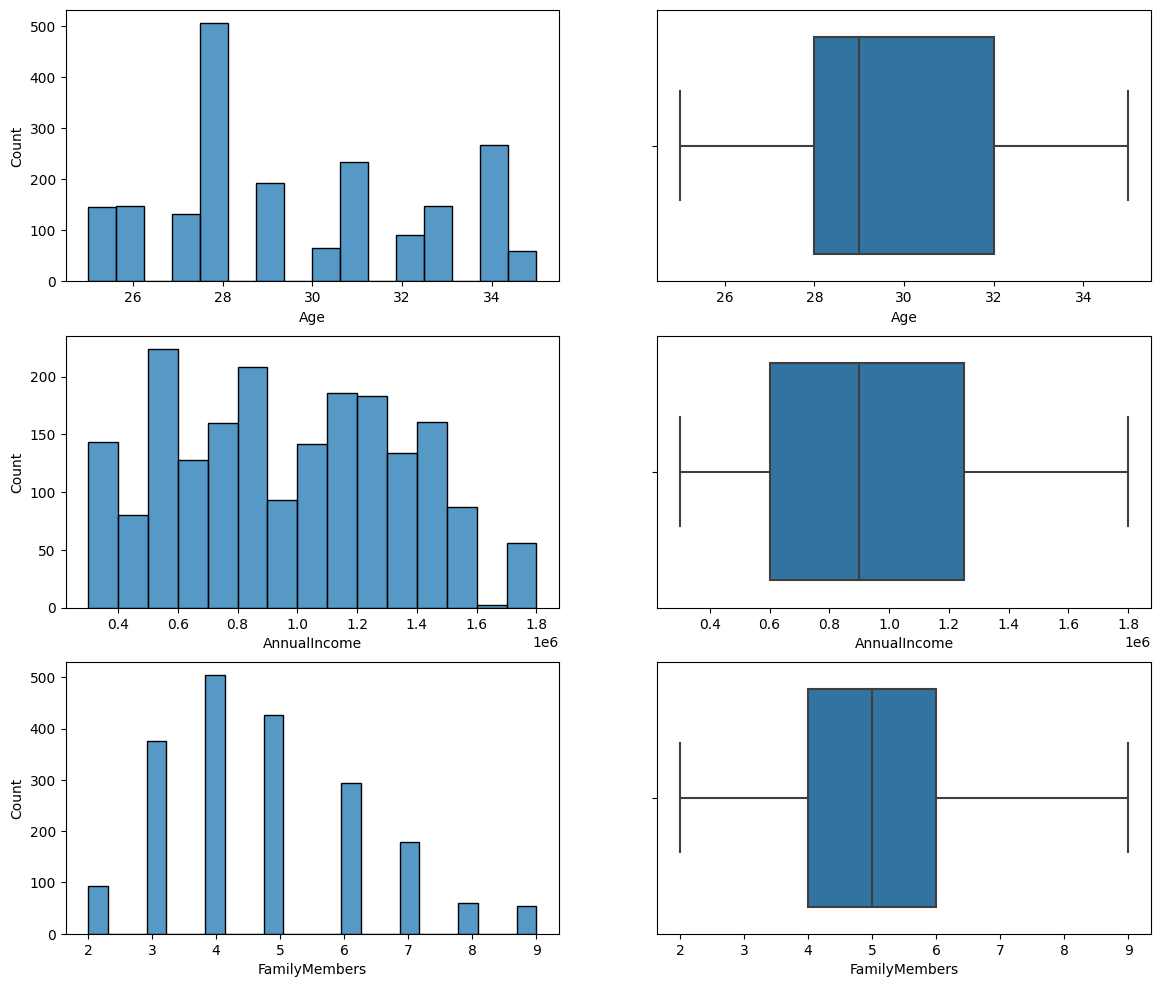

In [7]:
fig, axes = plt.subplots(nrows=len(num_cols), ncols=2, figsize=(14, 12))
for i, col in enumerate(num_cols):
    sns.histplot(data=data, x=col, ax=axes[i][0])
    sns.boxplot(data=data, x=col, ax=axes[i][1])

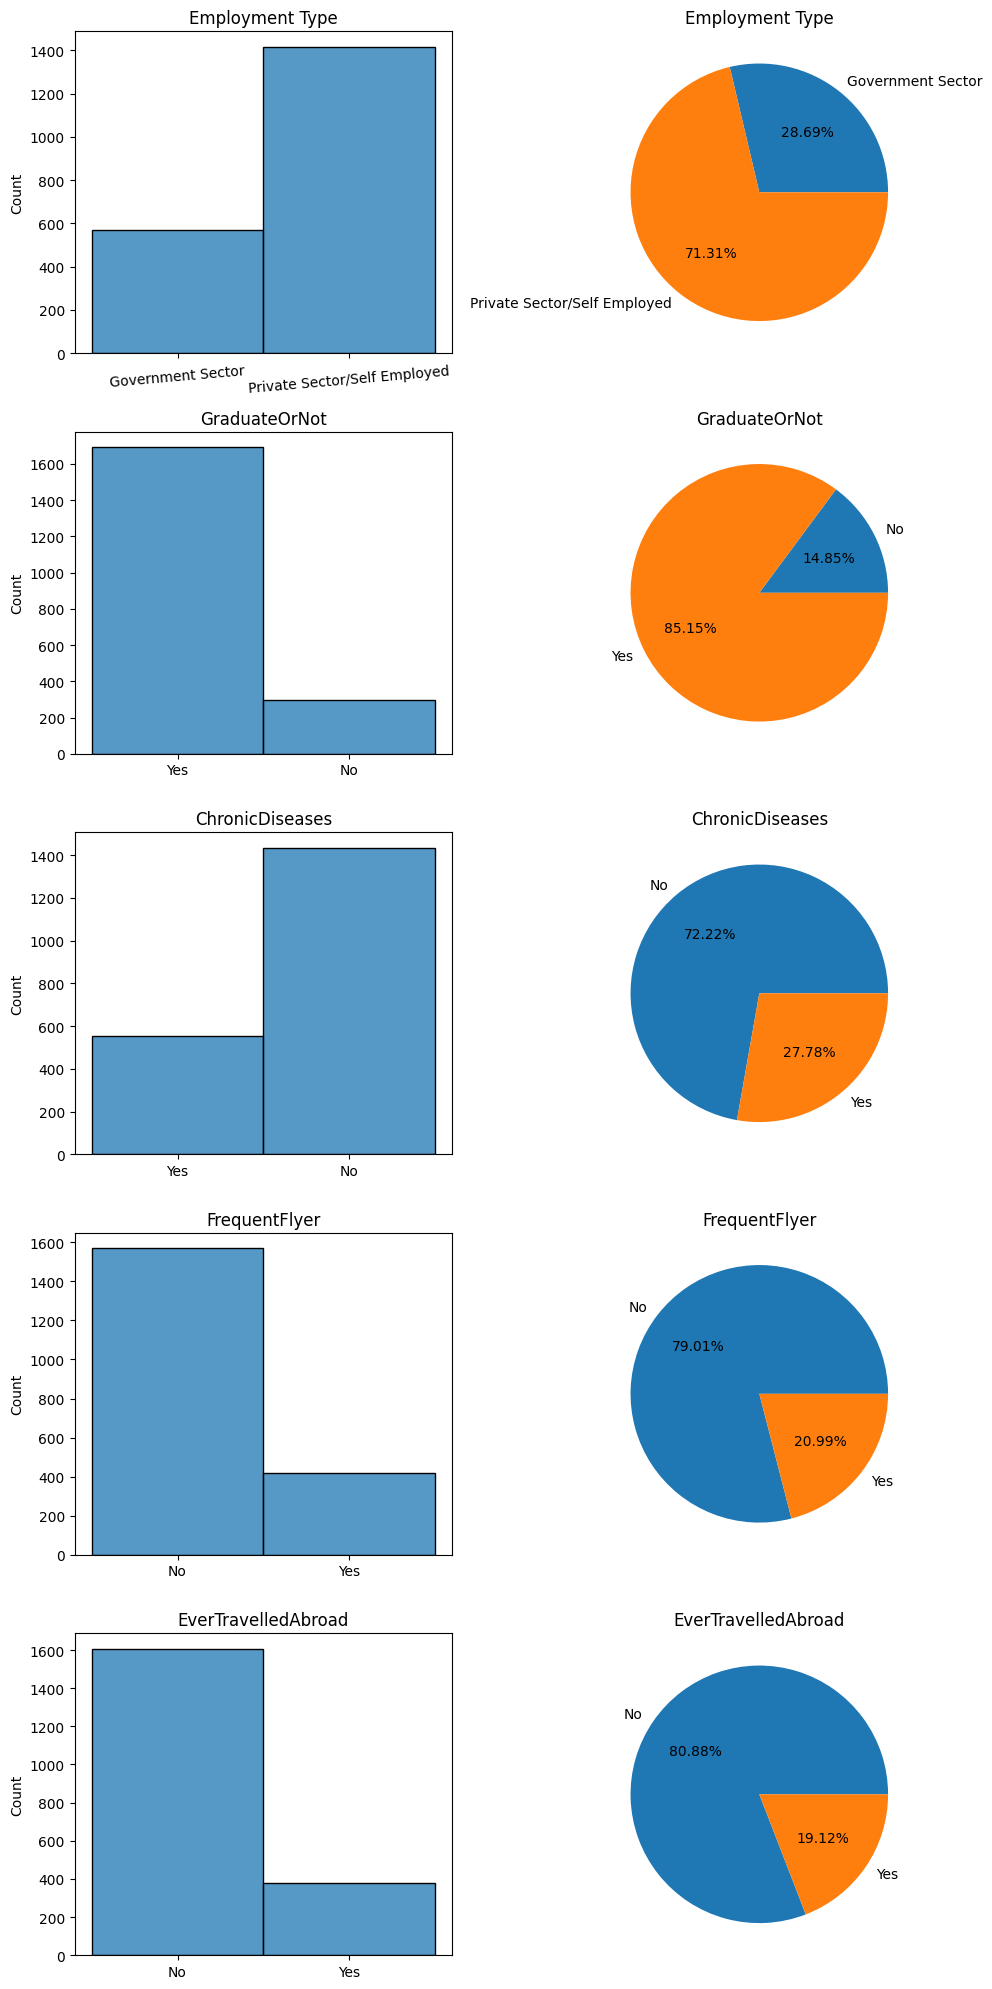

In [8]:
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=2, figsize=(10, 20))
for i, col in enumerate(cat_cols):
    sns.histplot(data=data, x=col, ax=axes[i][0])
    data.groupby(col).size().plot(kind='pie', autopct='%.2f%%', ax=axes[i][1])
    axes[i][0].set_title(col)
    axes[i][1].set_title(col)
    axes[i][0].set_xlabel(None)
    axes[i][1].set_ylabel(None)
xtick_labels = axes[0][0].get_xticklabels()
for label in xtick_labels:
    label.set_rotation(5)
plt.tight_layout()

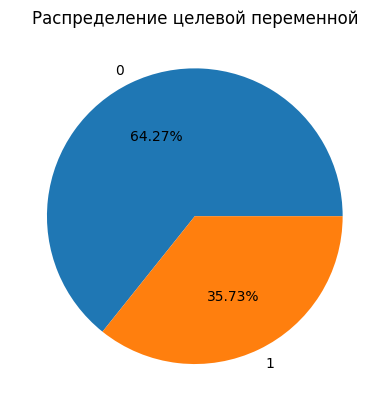

In [9]:
ax = data.groupby(target_col).size().plot(kind='pie', autopct='%.2f%%')
ax.set_ylabel(None)
ax.set_title('Распределение целевой переменной');

Как видно из графика, целевая переменная более-менее сбалансирована.

Разобьем данные на трейн и тест.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data[feature_cols], data[target_col], stratify=data[target_col], test_size=0.2, random_state=2023)

Далее с помощью кросс-валидации и GridSearch будем подбирать гиперпараметры на трейне, получим модель, обученную с этими гиперпараметрами на всём трейне, затем сделаем предсказания на тест.

В качестве предобработки сделаем пайплайн, числовые признаки отскалируем с помощью StandardScaler, категориальные - с помощью OneHotEncoder. В OneHotEncoder используем drop = 'if_binary' (хотя и так все категориальные признаки бинарные и это было бы эквивалентно drop = 'first'), для исключения двух, по сути, одинаковых столбцов.

### Логистическая регрессия

Наилучшие параметры модели: {'C': 0.01, 'solver': 'liblinear'}
F1-score наилучшей модели: 0.635987253132515

              precision    recall  f1-score   support

           0       0.76      0.93      0.83       256
           1       0.78      0.46      0.58       142

    accuracy                           0.76       398
   macro avg       0.77      0.70      0.71       398
weighted avg       0.76      0.76      0.74       398




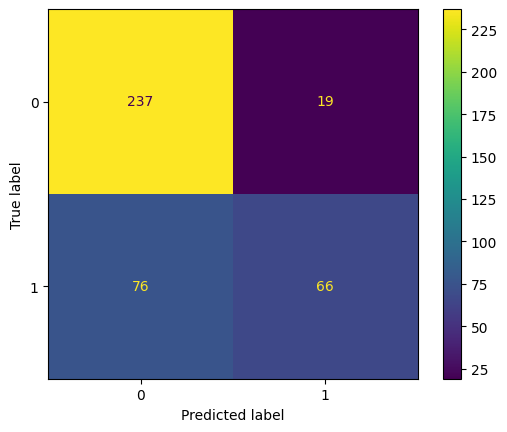

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='if_binary'), cat_cols)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('logisticregression', LogisticRegression())
])

param_grid = {
    'logisticregression__C': [100, 10, 1, 0.1, 0.01, 0.001],
    'logisticregression__solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
}

grid_search_lr = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, refit=True)


grid_search_lr.fit(X_train, y_train)


print("Наилучшие параметры модели:", {k.replace('logisticregression__', ''): v for k, v in grid_search_lr.best_params_.items()})
print("F1-score наилучшей модели:", grid_search_lr.best_score_)

lr = grid_search_lr.best_estimator_
logreg_pred = lr.predict(X_test)

print()
print(classification_report(y_test, logreg_pred))
print()
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, logreg_pred, labels=lr.classes_), display_labels=lr.classes_).plot();

### SVM

Наилучшие параметры модели: {'C': 10, 'class_weight': None, 'kernel': 'rbf'}
F1-score наилучшей модели: 0.715939418509404

              precision    recall  f1-score   support

           0       0.77      0.93      0.84       256
           1       0.80      0.51      0.62       142

    accuracy                           0.78       398
   macro avg       0.79      0.72      0.73       398
weighted avg       0.78      0.78      0.76       398




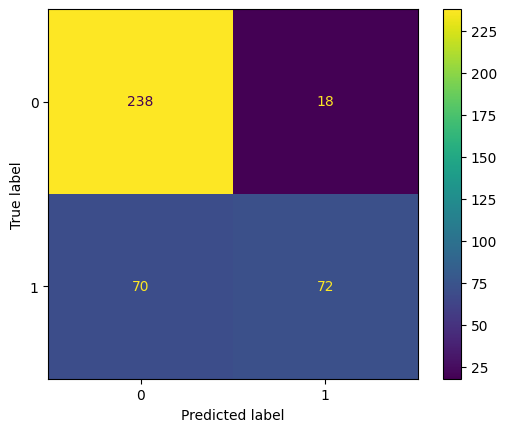

In [12]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('SVC', SVC())
])

param_grid = {
    'SVC__C': [1, 10, 100],
    'SVC__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'SVC__class_weight': [None, 'balanced']
}

grid_search_svc = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, refit=True)


grid_search_svc.fit(X_train, y_train)


print("Наилучшие параметры модели:", {k.replace('SVC__', ''): v for k, v in grid_search_svc.best_params_.items()})
print("F1-score наилучшей модели:", grid_search_svc.best_score_)

svc = grid_search_svc.best_estimator_
svc_pred = svc.predict(X_test)

print()
print(classification_report(y_test, svc_pred))
print()
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, svc_pred, labels=svc.classes_), display_labels=svc.classes_).plot();

### KNN

Наилучшие параметры модели: {'metric': 'euclidean', 'n_neighbors': 26, 'weights': 'distance'}
F1-score наилучшей модели: 0.7090283562321478

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       256
           1       0.72      0.55      0.62       142

    accuracy                           0.76       398
   macro avg       0.75      0.71      0.72       398
weighted avg       0.76      0.76      0.75       398




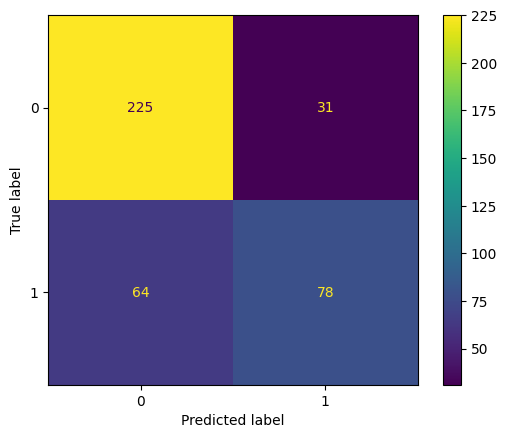

In [13]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('KNN', KNeighborsClassifier(n_jobs=-1))
])

param_grid = {
    'KNN__n_neighbors': np.arange(1, 30),
    'KNN__weights': ['uniform', 'distance'],
    'KNN__metric': ['manhattan', 'cosine', 'euclidean']
}

grid_search_knn = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, refit=True)


grid_search_knn.fit(X_train, y_train)


print("Наилучшие параметры модели:", {k.replace('KNN__', ''): v for k, v in grid_search_knn.best_params_.items()})
print("F1-score наилучшей модели:", grid_search_knn.best_score_)

knn = grid_search_knn.best_estimator_
knn_pred = knn.predict(X_test)

print()
print(classification_report(y_test, knn_pred))
print()
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, knn_pred, labels=knn.classes_), display_labels=knn.classes_).plot();

### Выводы

In [14]:
res = pd.DataFrame({'LogReg': [0.76, 0.78, 0.46, 0.58], 'SVM': [0.78, 0.8, 0.51, 0.62], 'KNN': [0.76, 0.72, 0.55, 0.62]},
                   index=['Accuracy', 'Precision', 'Recall', 'F1'])
res

,LogReg,SVM,KNN
Accuracy,0.76,0.78,0.76
Precision,0.78,0.80,0.72
Recall,0.46,0.51,0.55
F1,0.58,0.62,0.62


Для начала, стоит заметить, что доля правильных ответов (Accuracy) у трех моделей примерно одинаковая, но по ней нельзя судить о качестве их предсказаний. Так что будем рассматривать F1-score, Precision и Recall.

Хуже всех по этим показателям себя показала логистическая регрессия. 

Примечательно, что SVC и KNeighborsClassifier показали одинаковый F1-score, равный 0.62. 
Только SVC показывают лучшую точность (Precision), а KNeighborsClassifier - лучшую полноту (Recall).
В контексте определения того, купит ли клиент страховку, наверное важнее будет полнота, так как все те клиенты, которых модель предсказала как
False Negative - это упущенные клиенты, которые купили бы нашу страховку, но мы их проигнорировали. А False Positive в данному случае - это те клиенты,
которые не купили страховку, но мы подумали что они ее купят, в худшем случае мы потратили на них немного времени и средств на усиленную рекламу (или какие-то другие действия). Конечно, у каждой конкретной компании свои бизнес-цели, и, возможно, для кого-то будет важным обратное.